In [1]:
%load_ext autoreload
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sncosmo

In [2]:
import os
from copy import deepcopy

In [3]:
import gedankenLSST
import numpy as np
import pandas as pd

In [4]:
from LSSTmetrics import PerSNMetric

In [5]:
import LSSTmetrics

In [6]:
LSSTmetrics.__file__

'/Users/rbiswas/.local/lib/python2.7/site-packages/LSSTmetrics/__init__.pyc'

In [7]:
LSSTmetrics.__version__

'0.0.4dev'

In [8]:
from lsst.sims.photUtils import BandpassDict

## Some setup 

In [9]:
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [10]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


### Example of SVD Cadence

In [21]:
SVDCadence = deepcopy(gedankenLSST.LSSTReq)

In [23]:
# This is a dictionary with the following keys
SVDCadence.keys()

['Duration', 'bF', 'meanNumVisits', 'medianSVD']

In [24]:
SVDCadence['Duration']

3650.0

In [25]:
SVDCadence['bF']

u    1
g    1
r    1
i    1
z    1
y    1
dtype: float64

In [26]:
SVDCadence['meanNumVisits']

u     56
g     80
r    184
i    184
z    160
y    160
dtype: float64

In [27]:
SVDCadence['medianSVD']

u    23.9
g    25.0
r    24.7
i    24.0
z    23.3
y    22.1
dtype: float64

In [29]:
#Now create a set of observations at a particular ra, dec within a a time window
SVD_obs = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=SVDCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-30., 50.])

In [36]:
SN_SVD = PerSNMetric(summarydf=SVD_obs.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

In [37]:
# What are the properties of the SN?

Hello
(19, Index([u'expMJD', u'filter', u'ra', u'dec', u'fiveSigmaDepth', u'fieldID',
       u'night'],
      dtype='object'))


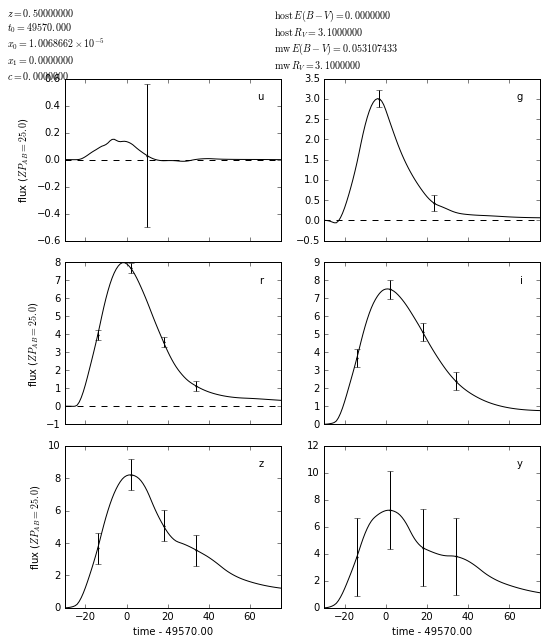

In [39]:
_ = SN_SVD.lcplot()

In [32]:
SN_SVD.SN.SNstate

{'MWE(B-V)': 0.053107433021068573,
 'ModelSource': 'salt2-extended',
 '_dec': -27.0,
 '_ra': 58.0,
 'c': 0.0,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 49570.0,
 'x0': 1.0068661711630977e-05,
 'x1': 0.0,
 'z': 0.5}

In [40]:
# Change the redshift
SN_SVD.redshiftSN(1.0)

In [41]:
SN_SVD.SN.SNstate

{'MWE(B-V)': 0.053107433021068573,
 'ModelSource': 'salt2-extended',
 '_dec': -27.0,
 '_ra': 58.0,
 'c': 0.0,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 49570.0,
 'x0': 1.838420175046384e-06,
 'x1': 0.0,
 'z': 1.0}

/Users/rbiswas/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SNR'] = df['flux'] / df['fluxerr']
/Users/rbiswas/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['DetectionEfficiency'] = df.apply(self.func, axis=1)


Hello
(19, Index([u'expMJD', u'filter', u'ra', u'dec', u'fiveSigmaDepth', u'fieldID',
       u'night'],
      dtype='object'))


/Users/rbiswas/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.sort_values('SNR', ascending=False, inplace=True)


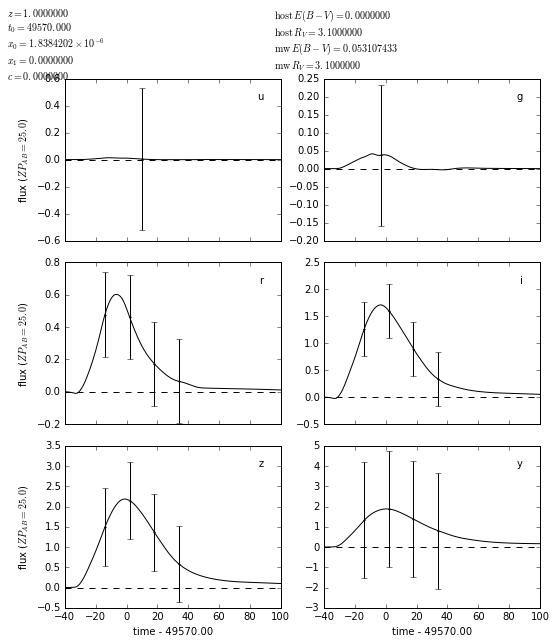

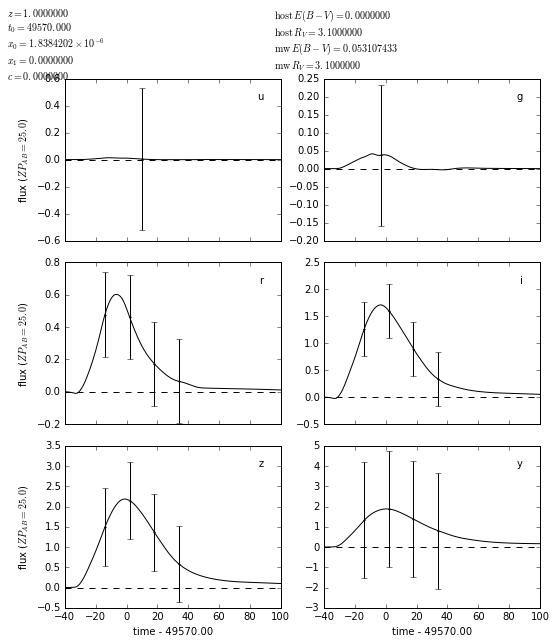

In [42]:
SN_SVD.lcplot()

In [50]:
snDaily.qualityMetric()

Hello
(19, Index([u'expMJD', u'filter', u'ra', u'dec', u'fiveSigmaDepth', u'fieldID',
       u'night'],
      dtype='object'))


0.24831543189185717

### Example of Daily Cadence

Here we set up an example where the SN are measured at a daily cadence

In [43]:
dailyCadence = deepcopy(gedankenLSST.LSSTReq)

In [44]:
# This is a dictionary with the following keys
dailyCadence.keys()

['Duration', 'bF', 'meanNumVisits', 'medianSVD']

In [13]:
dailyCadence['Duration'] # Says the survey is 10 years

3650.0

In [14]:
dailyCadence['meanNumVisits'] # Gives the number of visits during the duration, (mean is over LSST fields)

u     56
g     80
r    184
i    184
z    160
y    160
dtype: float64

In [15]:
dailyCadence['bF'] # bumpFactors increase the cadence in filters by these factors

u    1
g    1
r    1
i    1
z    1
y    1
dtype: float64

In [16]:
dailyCadence['medianSVD'] # median single visit 5 sigma depth in LSST

u    23.9
g    25.0
r    24.7
i    24.0
z    23.3
y    22.1
dtype: float64

In [17]:
# Now, we will make the cadence a 'daily cadence' in each band
dailyCadence['meanNumVisits'] = pd.Series(np.repeat(3650.,6), index=['u','g','r','i','z','y'], copy=True)

In [18]:
dailyCadence['meanNumVisits']

u    3650
g    3650
r    3650
i    3650
z    3650
y    3650
dtype: float64

In [45]:
#Now create a set of observations at a particular ra, dec within a a time window
observations = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=dailyCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-30., 50.])

In [46]:
# This is a pandas.DataFrame which should look like columns of OpSim
observations.summary.head()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night
0,49540.000000,g,58,-27,25,1,49540
1,49566.666667,g,58,-27,25,1,49566
2,49593.333333,g,58,-27,25,1,49593
3,49540.000000,i,58,-27,24,1,49540
4,49556.000000,i,58,-27,24,1,49556


In [47]:
snDaily = PerSNMetric(summarydf=observations.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

In [48]:
snDaily.SN.SNstate

{'MWE(B-V)': 0.053107433021068573,
 'ModelSource': 'salt2-extended',
 '_dec': -27.0,
 '_ra': 58.0,
 'c': 0.0,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 49570.0,
 'x0': 1.0068661711630977e-05,
 'x1': 0.0,
 'z': 0.5}

Hello
(19, Index([u'expMJD', u'filter', u'ra', u'dec', u'fiveSigmaDepth', u'fieldID',
       u'night'],
      dtype='object'))


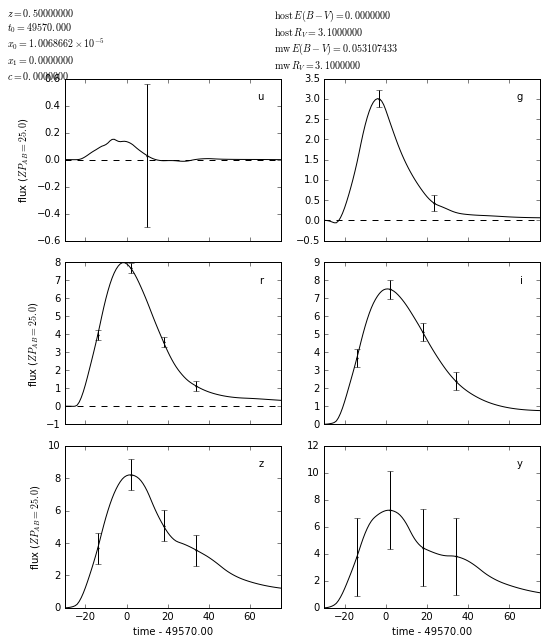

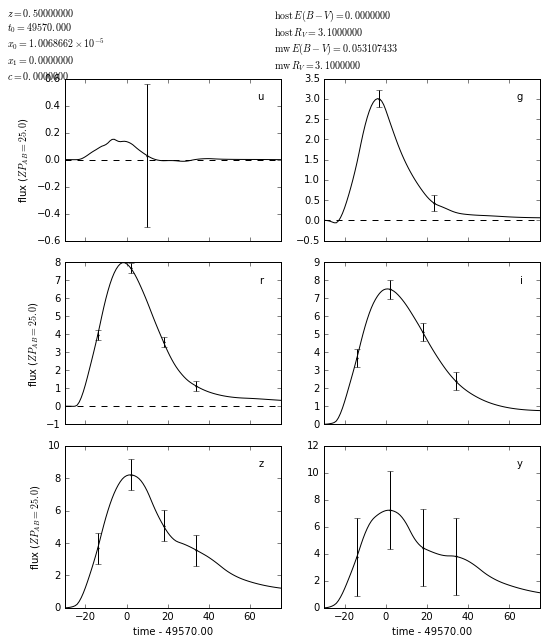

In [49]:
snDaily.lcplot()

In [ ]:
snDaily.redshiftSN(1.0)

In [ ]:
snDaily.SN.SNstate

In [ ]:
snDaily.lcplot()

In [ ]:
from lsst.sims.catUtils.supernovae import SNObject

In [ ]:
snobj = SNObject.fromSNState(snstate)

In [ ]:
snstate

In [ ]:
snobj.SNstate

In [ ]:
# Now we can look at a light curve (no scatter)
snDaily.lightcurve.head()

In [ ]:
# We can coadd the light curve in nights if necessary
snDaily.coaddedLightCurve.head()

In [ ]:
# We can get plots with scatter, and a seed. This can also have a nightly coadd 
snDaily.lcplot(scattered=True, seed=0)

In [ ]:
# the same light curves in a format where we can easily fit
snDaily.SNCosmoLC()

#### An LSST Cadence

In [ ]:
lsstCadence = deepcopy(gedankenLSST.LSSTReq)

In [ ]:
lsst_obs = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=lsstCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-30., 50.])

In [ ]:
lsstCadence

In [ ]:
snLSST = PerSNMetric(summarydf=lsst_obs.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

In [ ]:
snLSST.lcplot()

In [ ]:
snLSST.SNCosmoLC()

####  Using BumpFactor

In [ ]:
thriceLsstCadence = deepcopy(gedankenLSST.LSSTReq)

In [ ]:
thriceLsstCadence['bF'] = 3

In [ ]:
lsst_Denseobs = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=thriceLsstCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-30., 50.])

In [ ]:
snLSSTdense = PerSNMetric(summarydf=lsst_Denseobs.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

In [ ]:
snLSSTdense.lcplot(scattered=True)

# Scratch

In [ ]:
df = sn.summary

In [ ]:
df['filter'].unique()

In [ ]:
df.columns

In [ ]:
df[df['filter'] == 'u'].hist('night',bins=80)

In [ ]:
s = gedankenLSST.SNObs(summarydf=df, t0=49530, lsst_bp=lsst_bp)

In [ ]:
np.degrees(0)

In [ ]:
s.radeg

In [ ]:
l = s.lightcurve

In [ ]:
type(l)

In [ ]:
l.query('SNR > 5.').night

In [ ]:
import sncosmo

In [ ]:
dir(sn)